# MNE decoding

In [1]:
# import python packages, path and definitions
import os
import os.path as op
import mne
from mne.decoding import SlidingEstimator, GeneralizingEstimator
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
fname_epo = 'bids_data/derivatives/stimulus_epoch_preprocessing/sub-02/ses-01/meg/sub-02_ses-01_task-WorkingMemory_meg-epo.fif'
fname_behav= 'bids_data/sub-02/ses-01/behavdata/WorkMem_sub02.csv'

# Data preparation

In [2]:
epochs = mne.read_epochs(fname_epo)

Reading C:\Users\pauli\Documents\PracticalMEEG\2023\LyonCutting_MNE_2023-main\LyonCutting_MNE_2023-main\bids_data\derivatives\stimulus_epoch_preprocessing\sub-02\ses-01\meg\sub-02_ses-01_task-WorkingMemory_meg-epo.fif ...
    Read 5 compensation matrices
    Found the data of interest:
        t =    -200.00 ...     900.00 ms
        5 CTF compensation matrices available
Not setting metadata
424 matching events found
No baseline correction applied
0 projection items activated


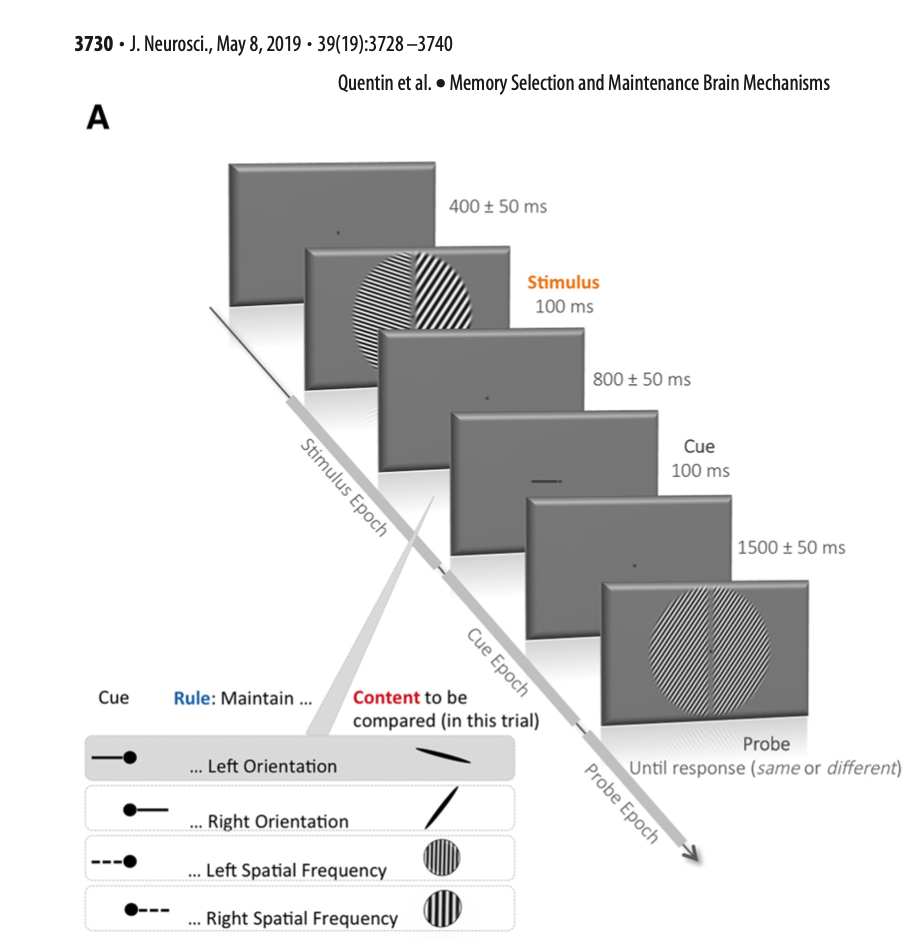

In [3]:
# read the behavioral file and output the spatial frequency on the left and on the right
behav = pd.read_csv(fname_behav, skiprows=1)
print(behav)
left_sf = behav['sfLeft']

     NbTrial  FixNbTrial  isFixed  GaborLeft  GaborRight  Cue  Change  sfLeft  \
0          1           1        0         15           9    1       0       3   
1          2           1        1         21          24    4       1       5   
2          3           2        1          1          20    1       1       1   
3          4           3        0         23           7    3       1       5   
4          5           3        1          7           8    4       1       2   
..       ...         ...      ...        ...         ...  ...     ...     ...   
419      420         396        1          9          24    2       1       2   
420      421         397        1         16          14    4       0       4   
421      422         398        1         17          24    4       0       4   
422      423         399        1         10          11    1       0       2   
423      424         400        1         19          23    3       1       4   

     orientLeft  phaseLeft 

In [4]:
# Remove trials with a blink (based on the eyetracker info in the behavioral file )
is_fixed = np.array(behav['isFixed'])
epochs.drop(~is_fixed.astype(bool))

Dropped 24 epochs: 0, 3, 5, 8, 11, 14, 23, 25, 29, 31, 35, 39, 51, 150, 167, 173, 208, 317, 333, 344, 353, 359, 411, 416


<EpochsFIF |  400 events (all good), -0.2 – 0.9 s, baseline -0.2 – 0 s, ~125.5 MB, data loaded,
 'stimulus1': 4
 'stimulus2': 6
 'stimulus3': 9
 'stimulus4': 2
 'stimulus5': 9
 'stimulus6': 7
 'stimulus7': 7
 'stimulus8': 12
 'stimulus9': 13
 'stimulus10': 11
 and 115 more events ...>

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


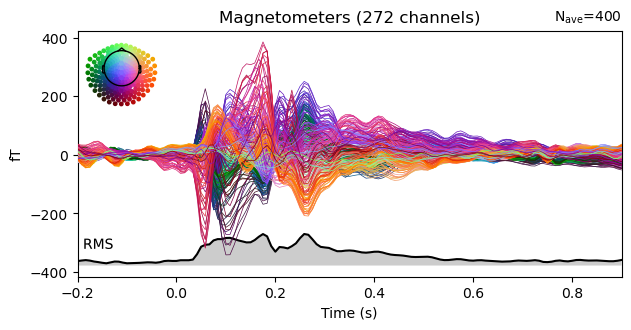

In [5]:
# plot the evoked
epochs.average().plot(spatial_colors=True, gfp=True);

# What is MVPA?
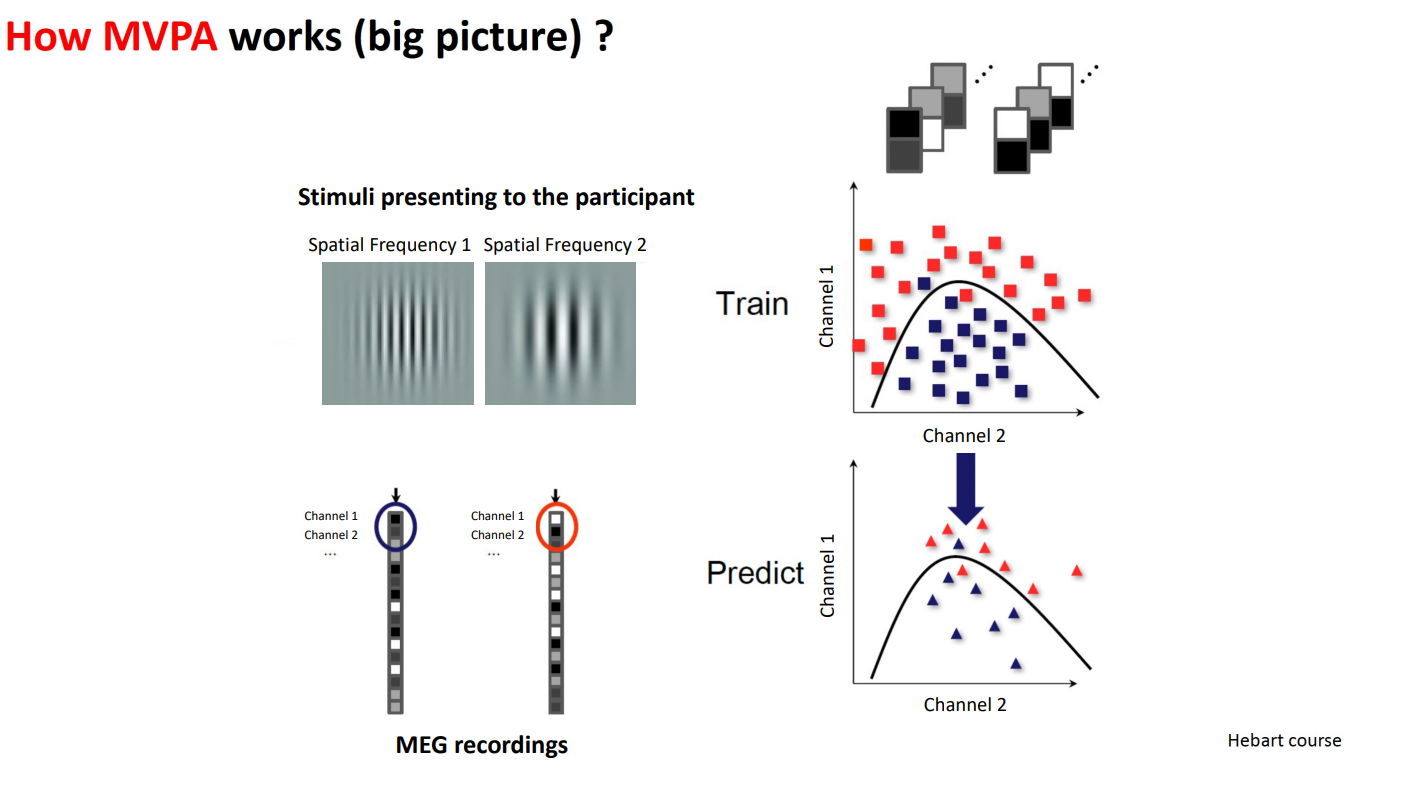

## Arranging the data for decoding

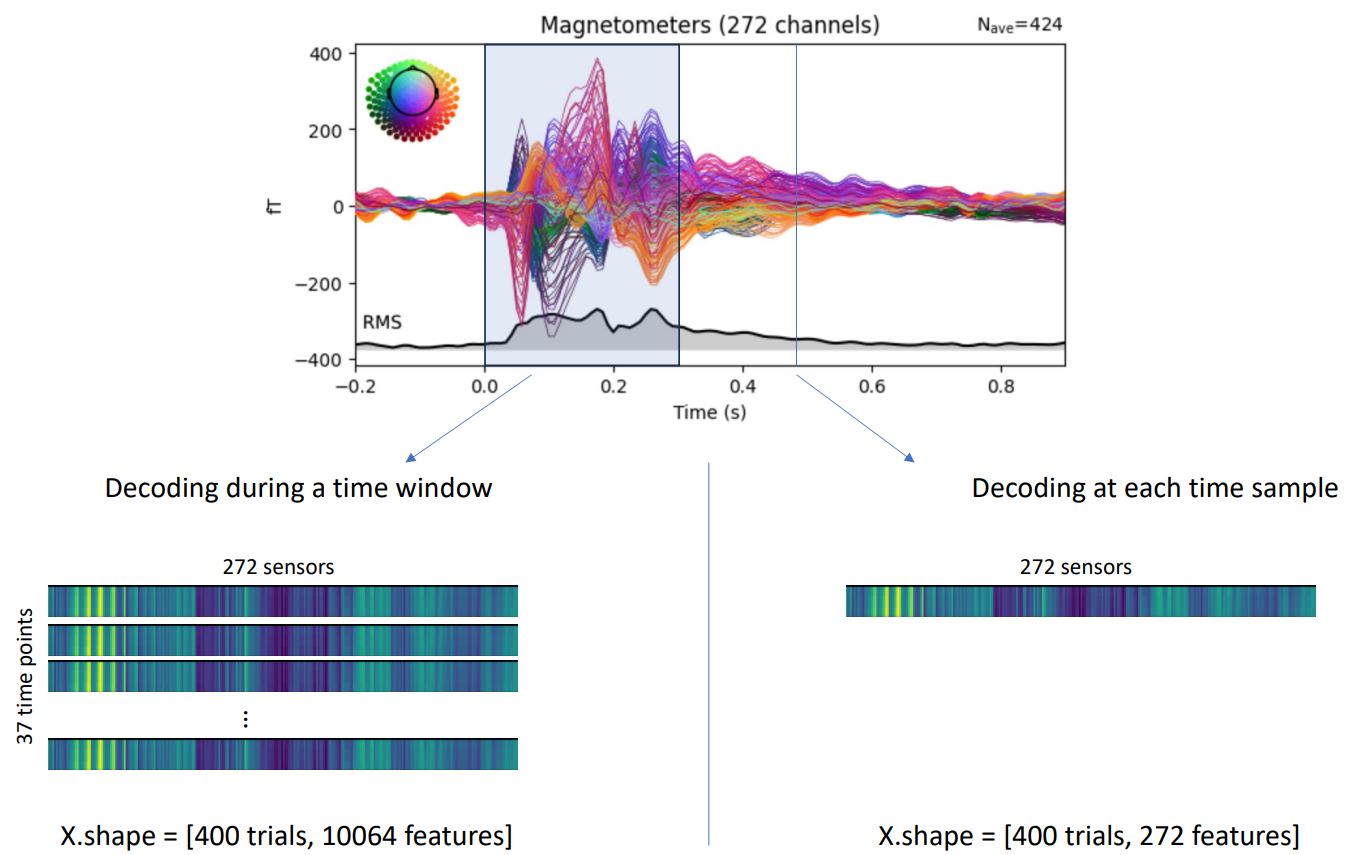

In [6]:
# Arrange the data in arrays
# The y variable contains the labels
y = np.array(left_sf, dtype=float)[is_fixed.astype(bool)]
# We can be interested in classifitying data from each time point around the stimuli
X_time_points = epochs.pick_types(meg=True, ref_meg=False, stim=False).get_data()

# We can be interested in classifitying data from a time window around the stimuli
# Define the time window
t_min = 0
t_max = 0.3
# Crop the epochs 
cropped_epochs = epochs.copy().crop(tmin=t_min, tmax=t_max)
X_windows = cropped_epochs.pick_types(meg=True, ref_meg=False, stim=False).get_data()
# Reshape the cropped epoch data to have dim[0] = nb_samples; dim[1] = nb_MEG_channels * nb_time_points
X_windows = X_windows.reshape(X_windows.shape[0], X_windows.shape[1]*X_windows.shape[2])

# Print the shape of variables to check they are correct
print("Shape of the X_windows data array: ", X_windows.shape)
print("Shape of the X_time_points data array: ", X_time_points.shape)
print("Shape of the labels array: ", y.shape)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Shape of the X_windows data array:  (400, 10064)
Shape of the X_time_points data array:  (400, 272, 133)
Shape of the labels array:  (400,)


In [7]:
# Prepare data for a second subject (same as above)
fname_epo = 'bids_data/derivatives/stimulus_epoch_preprocessing/sub-03/ses-01/meg/sub-03_ses-01_task-WorkingMemory_meg-epo.fif'
fname_behav= 'bids_data/sub-03/ses-01/behavdata/WorkMem_sub03.csv'
epochs2 = mne.read_epochs(fname_epo)
behav2 = pd.read_csv(fname_behav, skiprows=1)

left_sf2 = behav2['sfLeft']
is_fixed2 = np.array(behav2['isFixed'])
epochs2.drop(~is_fixed2.astype(bool))

y2 = np.array(left_sf2, dtype=float)[is_fixed2.astype(bool)]
X_time_points2 = epochs2.pick_types(meg=True, ref_meg=False, stim=False).get_data()

cropped_epochs2 = epochs2.copy().crop(tmin=t_min, tmax=t_max)
X_windows2 = cropped_epochs2.pick_types(meg=True, ref_meg=False, stim=False).get_data()
X_windows2 = X_windows2.reshape(X_windows2.shape[0], X_windows2.shape[1]*X_windows2.shape[2])

print("Shape of the X_windows data array: ", X_windows2.shape)
print("Shape of the X_time_points data array: ", X_time_points2.shape)
print("Shape of the labels array: ", y2.shape)

Reading C:\Users\pauli\Documents\PracticalMEEG\2023\LyonCutting_MNE_2023-main\LyonCutting_MNE_2023-main\bids_data\derivatives\stimulus_epoch_preprocessing\sub-03\ses-01\meg\sub-03_ses-01_task-WorkingMemory_meg-epo.fif ...
    Read 5 compensation matrices
    Found the data of interest:
        t =    -200.00 ...     900.00 ms
        5 CTF compensation matrices available
Not setting metadata
436 matching events found
No baseline correction applied
0 projection items activated
Dropped 36 epochs: 0, 2, 6, 46, 54, 91, 99, 100, 104, 105, 116, 119, 123, 149, 153, 155, 164, 165, 169, 190, 205, 206, 215, 216, 224, 249, 265, 273, 274, 304, 305, 327, 340, 355, 386, 433
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Shape of the X_windows data array:  (400, 10064)
Shape of the X_time_points data array:  (40

## Labels
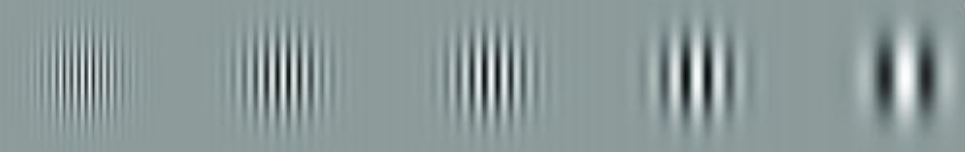

## Cross validation

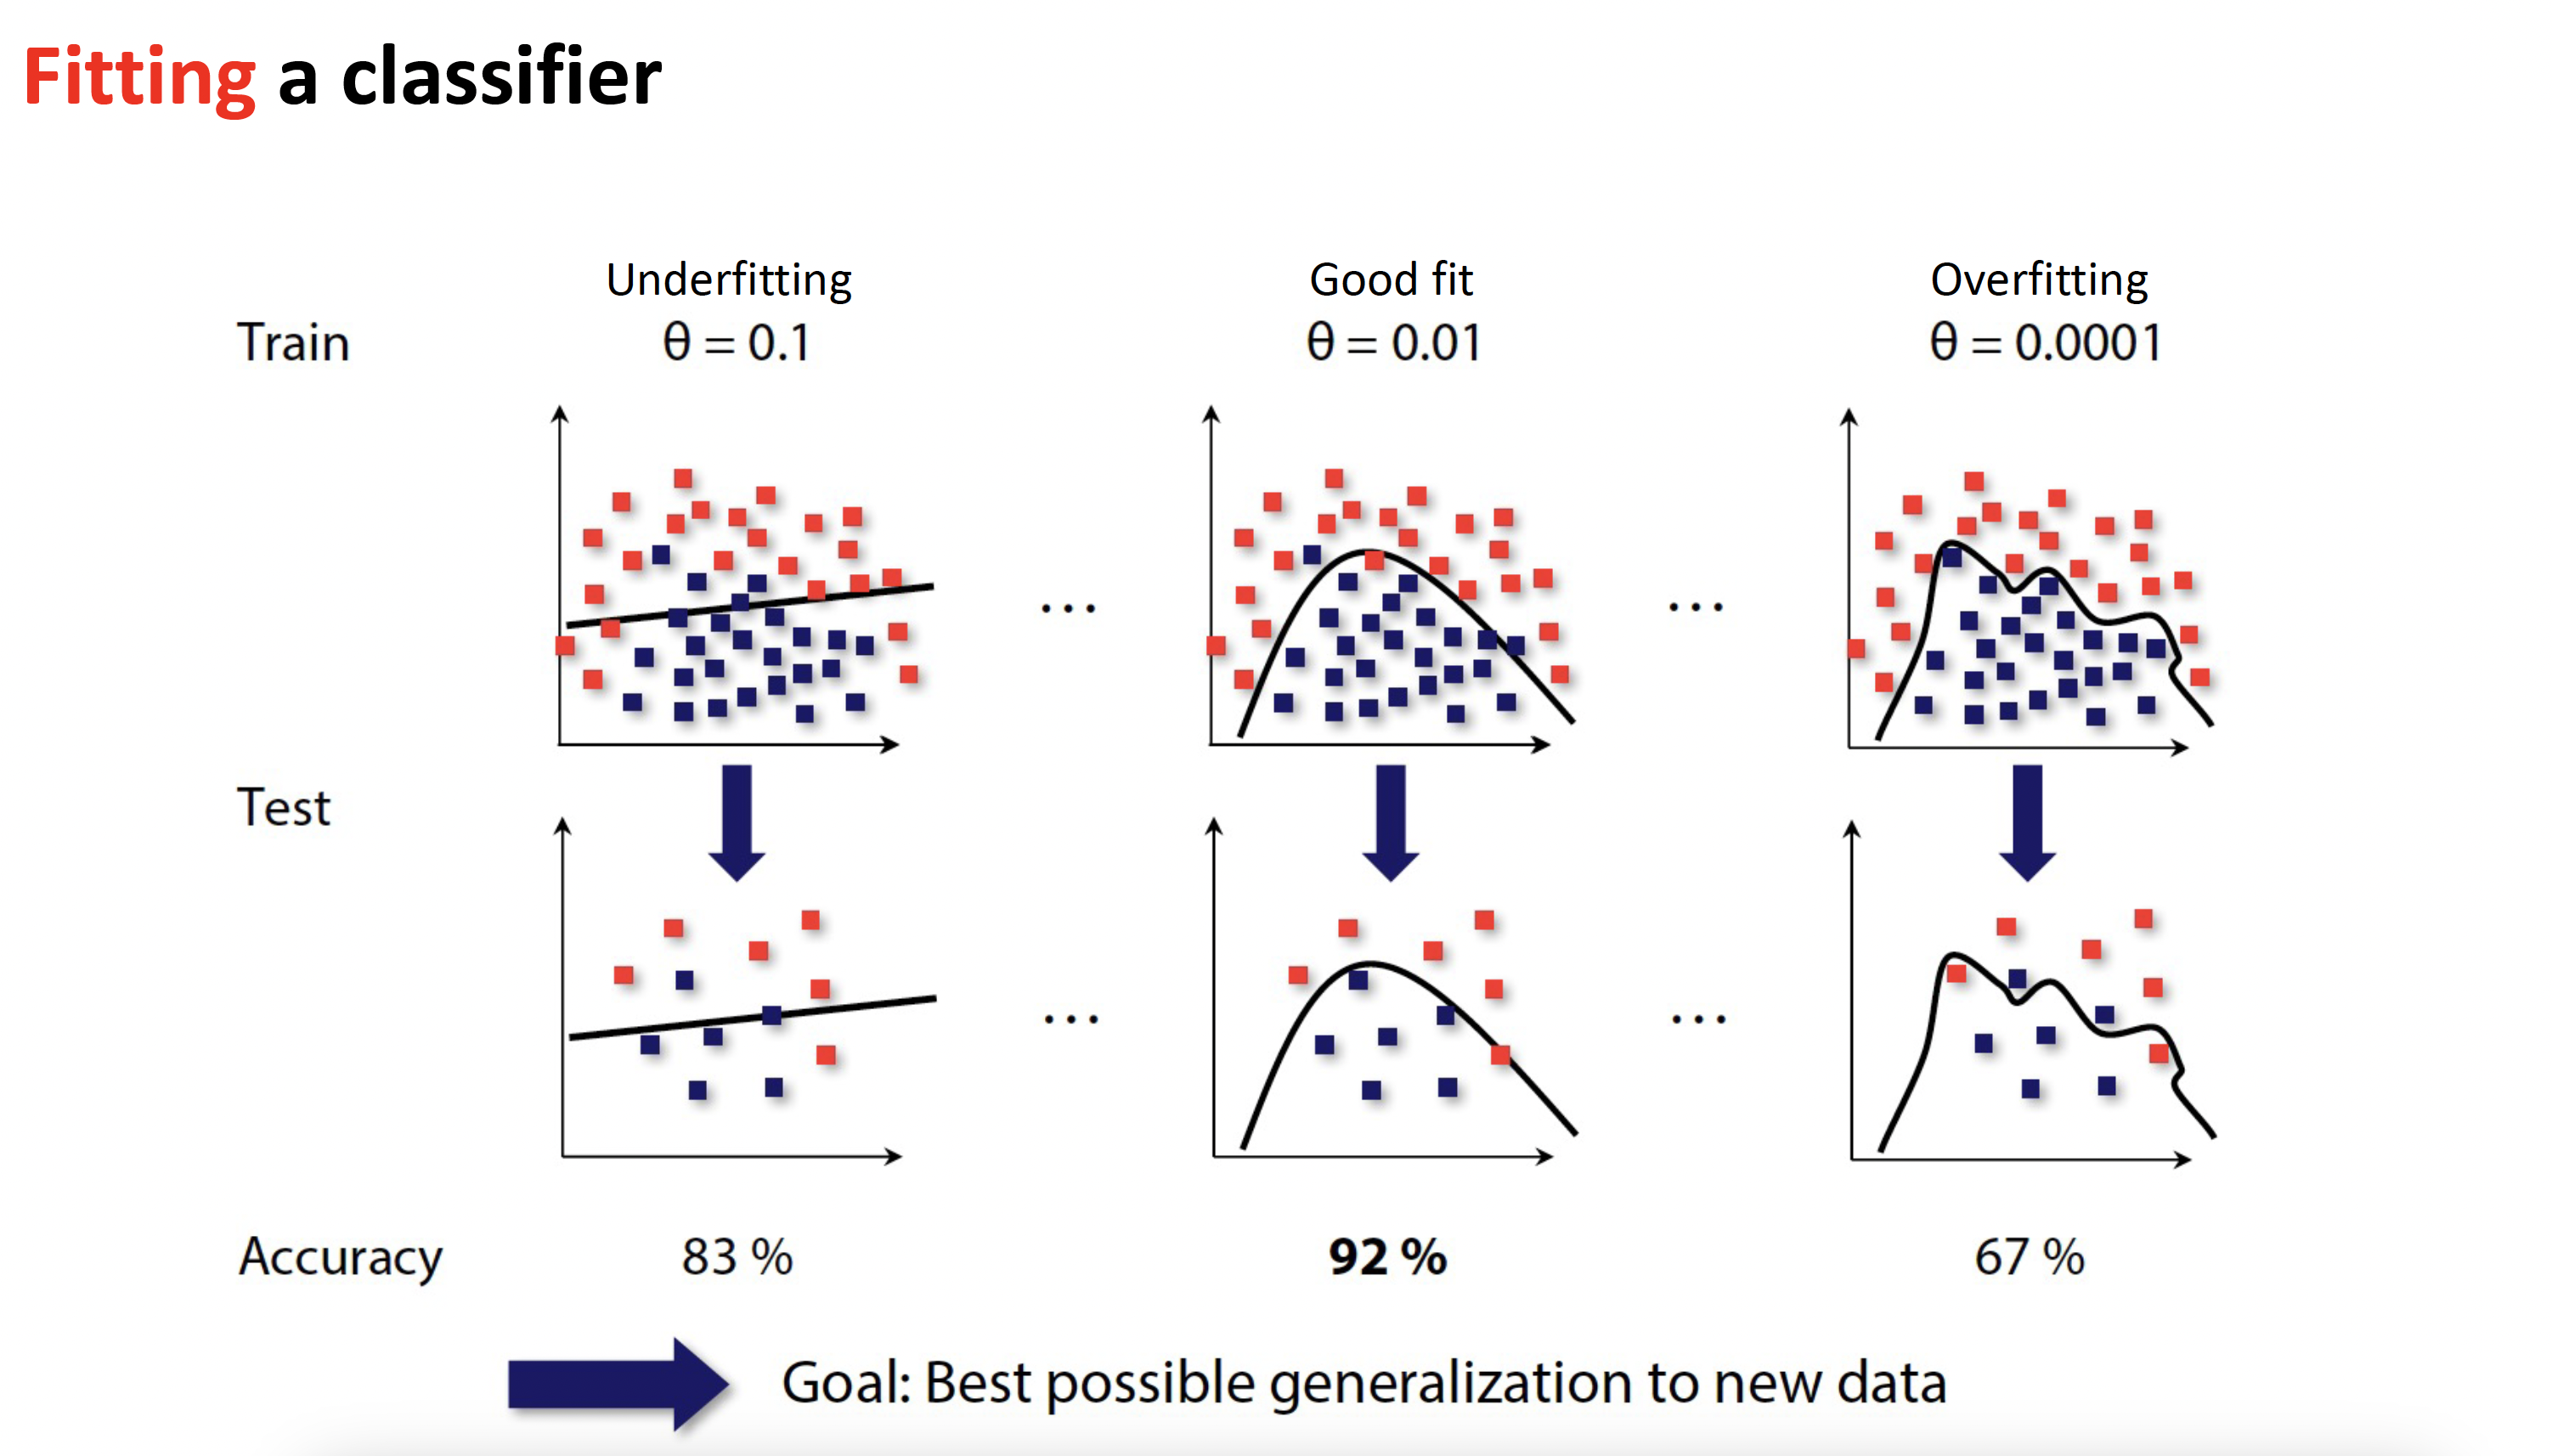

In [8]:
# Parametrize the cross validation scheme
nb_folds = 3
shuffle = False
stratified = False

In [9]:
# Instantiate the cross validation object
if stratified:
    kf = StratifiedKFold(nb_folds, shuffle=shuffle)
else:
    kf = KFold(nb_folds, shuffle=shuffle)

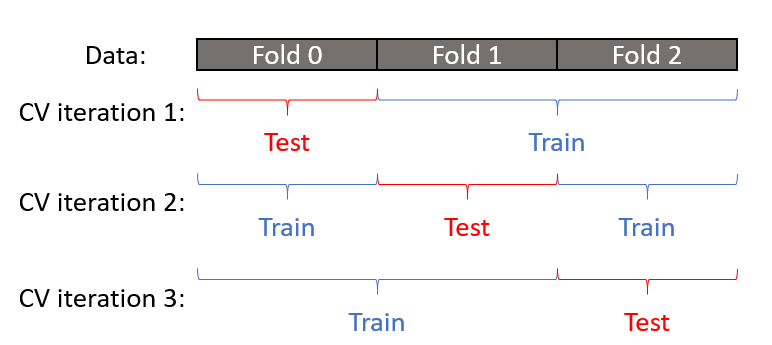

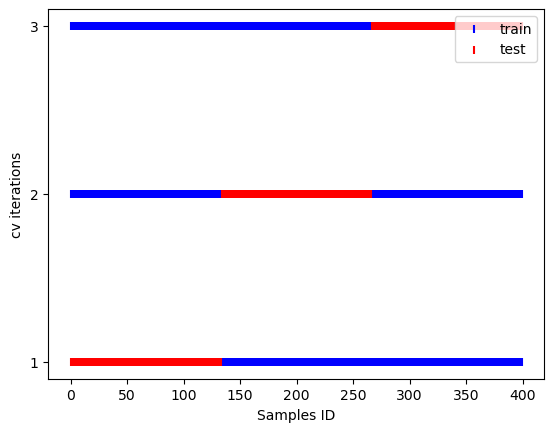

In [20]:
# plot the data split across cross validation folds
def plot_cv_iterations(kf,X,y):
    
    fold = 0
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # For each cross validation fold
    for train, test in kf.split(X,y):
        # Get the corresponding train and test labels
        y_test = y[test]
        y_train = y[train]
        # Plot the training and testing samples in different colors
        ax.scatter(train,np.ones(len(train))*fold,color='blue',marker='|')
        ax.scatter(test,np.ones(len(test))*fold,color='red',marker='|')
        plt.legend(["train","test"])
        ax.set_xlabel('Samples ID')
        ax.set_ylabel('cv iterations')
        ax.set_yticks(range(3))
        ax.set_yticklabels(range(4)[1:])
        fold = fold +1
    plt.show()
        
plot_cv_iterations(kf,X_windows,y)

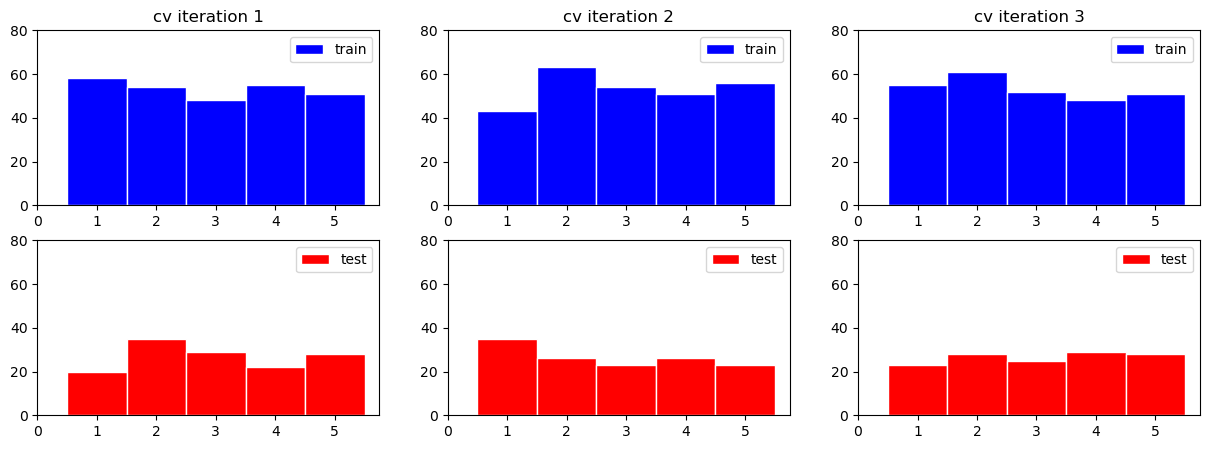

In [21]:
# Inspect data distribution across cross validation folds
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

def plot_hists(kf,X,y,nb_folds):
    fold = 1
    plt.figure(figsize=(15,5))
    # For each cross validation fold
    for train, test in kf.split(X,y):
        # Get the corresponding train and test labels
        y_test = y[test]
        y_train = y[train]
        # Plot the training and testing labels distribution 
        plt.subplot(2, nb_folds, fold)
        plt.title("cv iteration "+str(fold))
        plt.hist(y_train,bins=[1,2,3,4,5,6],color='blue',edgecolor='white',align='left')
        plt.ylim([0,80])
        plt.legend(["train"])
        plt.xticks(range(6))
        plt.subplot(2, nb_folds, fold+nb_folds)
        plt.hist(y_test,bins=[1,2,3,4,5,6],color='red',edgecolor='white',align='left')
        plt.ylim([0,80])
        plt.legend(["test"])
        plt.xticks(range(6))
        fold = fold+1
        
plot_hists(kf,X_windows,y,nb_folds)

<div class="alert alert-success">
    <b>Exercise</b>: Play with the cross validation parameters and observe the impact on the data
</div>

## Chance level accuracy prediction

In [22]:
# Before running our classifier, lets compute the chance level
# A naive classifier would classify all test samples to the majority class of the train samples
def compute_chance_levels(kf,X,y):
    chance_level=[]
    # For each cross validation fold
    for train, test in kf.split(X,y):
        # Get the corresponding train and test labels
        y_test = y[test]
        y_train = y[train]
        # Find the class with the most samples from the training data
        majority_class = np.argmax(np.bincount(y_train.astype('int64')))
        # The chance level corresponds to the percentage of data from the "majority_class" within the test data
        chance_level.append(np.bincount(y_test.astype('int64'))[majority_class]*100/y_test.shape)
    return(chance_level)

chance_levels = compute_chance_levels(kf,X_windows,y)
print("Chance levels for each cv iteration:")
print(chance_levels)

Chance levels for each cv iteration:
[array([14.92537313]), array([19.54887218]), array([21.05263158])]


<div class="alert alert-success">
    <b>Exercise</b>: How does the "stratified" parameter from the cross validation influences the chance levels?
</div>

# Classification on windows

In [23]:
# import different models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Instantaite different pipeline objects.
# The piplenies all start with standardizing the data, followed by a ML algorithm with modifiable parameters
mlp = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(50,),activation='logistic',max_iter=500))
lr = make_pipeline(StandardScaler(), LogisticRegression(multi_class='multinomial',max_iter=1000))
rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=200,max_depth=10))
nn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))


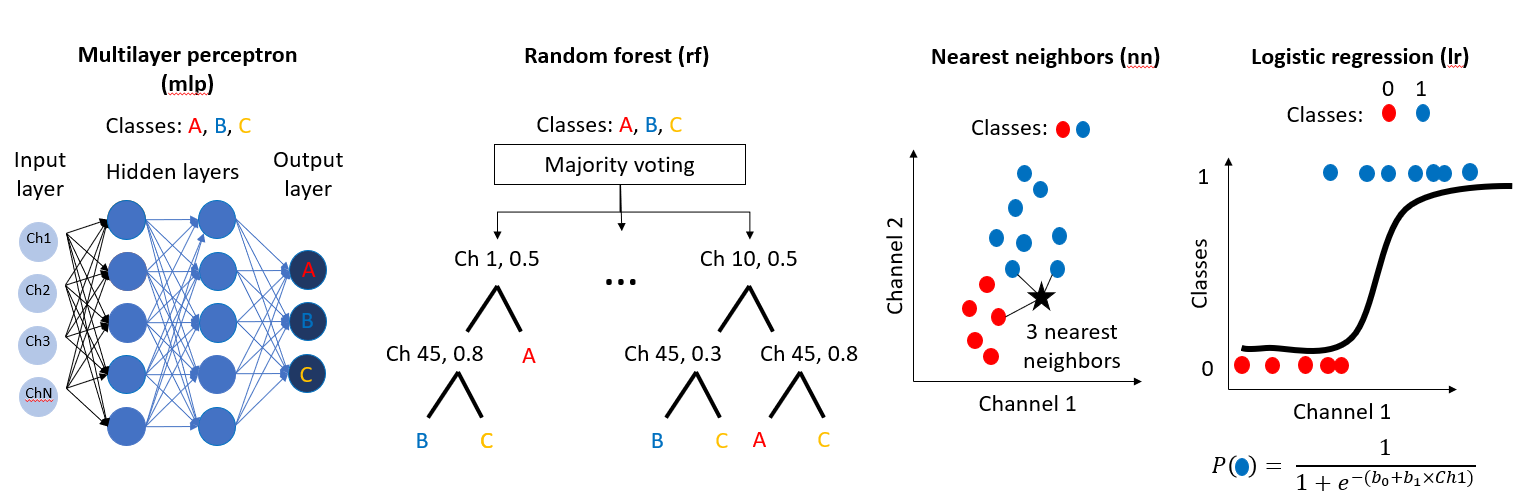

classification accuracy for cv iteration0:
0.6194029850746269
classification accuracy for cv iteration1:
0.6240601503759399
classification accuracy for cv iteration2:
0.6466165413533834
Mean classification accuracy across folds:  0.6300265589346501
Confusion matrix across folds: 


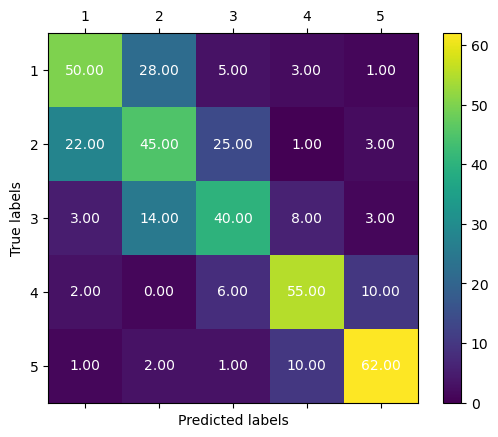

In [25]:
# Decoding the spatial frequency of the gabor stimuli from a short time window of MEG data sampled after the stimuli appears 

# Creating variables to store result metrics from each cross validation fold
accuracy_windows=[]
conf_matrix=np.zeros((5,5))
fold=0
# For each cross validation fold
for train, test in kf.split(X_windows,y):
    # Get the corresponding train and test data and labels
    X_train = X_windows[train]
    X_test = X_windows[test]
    y_train = y[train]
    y_test = y[test]
    # Select the pipeline object to use
    model = lr
    # Train the model with the train data
    model.fit(X_train, y_train)
    # Test the model with the test data
    # Return model predictions (int from 0 to 5)
    y_pred = model.predict(X_test)
    # Compute metrics by comparing predictions and ground truth labels
    accuracy_result = accuracy_score(y_test.astype('int64'),y_pred.astype('int64'))
    conf_matrix = conf_matrix + confusion_matrix(y_test.astype('int64'),y_pred.astype('int64'))
    # Print individual fold results
    print("classification accuracy for cv iteration"+str(fold)+":")
    print(accuracy_result)
    accuracy_windows.append(accuracy_result)
    fold=fold+1

# Print average across folds
print("Mean classification accuracy across folds: ", np.mean(accuracy_windows))
print("Confusion matrix across folds: ")
# Print confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)
for (i, j), value in np.ndenumerate(conf_matrix):
    plt.text(i, j, f"{value:.2f}", va="center", ha="center",c="white")
ax.set_xticks(range(5))
ax.set_xticklabels(range(6)[1:])
ax.set_yticks(range(5))
ax.set_yticklabels(range(6)[1:])
fig.colorbar(cax)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


<div class="alert alert-success">
    <b>Exercise 1</b>: Try different algorithms/algorithms parameters, observe how the results vary. Find a good set of parameters.<br />
     <b>Exercise 2</b>: So far, we have looked at the data from time point 0 to time point 0.3 after the event. Play with the lenght and time location of the window to observe changes in decoding perfomances.
</div>

# Classification on time points

Iteration
Iteration
Iteration
As a reminder, mean classification accuracy on windows was  0.6300265589346501


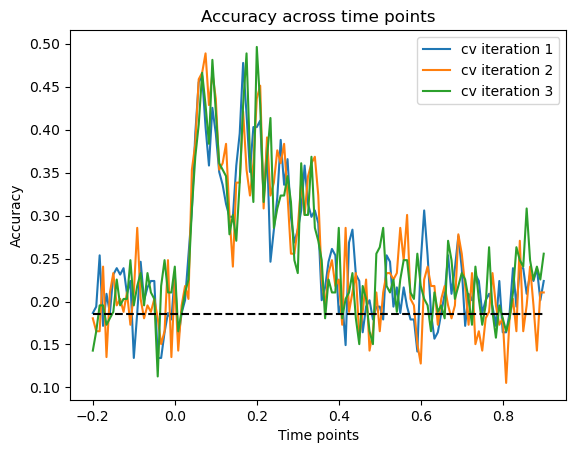

In [26]:
# Decoding the spatial frequency of the gabor stimuli from each time point of MEG data sampled after the stimuli appears 

# For each cross validation fold
for train, test in kf.split(X_time_points,y):
    print('Iteration')
    # Get the corresponding train and test data and labels
    X_train = X_time_points[train]
    X_test = X_time_points[test]
    y_train = y[train]
    y_test = y[test]
    # Select the pipeline object to use
    model = lr
    #  Creating variables to store result metrics from each time point
    per_tp_acc = np.empty(len(epochs.times))
    # For each time point in the epochs
    for tp in range(len(epochs.times)):
        # Train the model with the train data (of that specific time point); data.shape = nb sensors
        model.fit(X_train[:,:,tp], y_train)
        # Test the model with the test data (of that same specific time point); data.shape = nb sensors
        y_pred = model.predict(X_test[:,:,tp])
        # Store results for each time point
        #print(accuracy_score(y_test.astype('int64'),y_pred.astype('int64')))
        per_tp_acc[tp] = accuracy_score(y_test.astype('int64'),y_pred.astype('int64'))
    # For each cross validation fold, plot the accuracy obtained when training/testing on each time point
    plt.title("Accuracy across time points")
    plt.xlabel("Time points")
    plt.ylabel("Accuracy")
    plt.plot(epochs.times,per_tp_acc)
plt.legend(['cv iteration 1','cv iteration 2','cv iteration 3'])
plt.plot(epochs.times,np.repeat(np.mean(chance_levels)/100,len(epochs.times)),'--',color='black')
    
#Plot mean curve 

print("As a reminder, mean classification accuracy on windows was ", np.mean(accuracy_windows))

# Classification on time points using a sliding estimator

  0%|          | Fitting SlidingEstimator : 0/133 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/133 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/133 [00:00<?,       ?it/s]

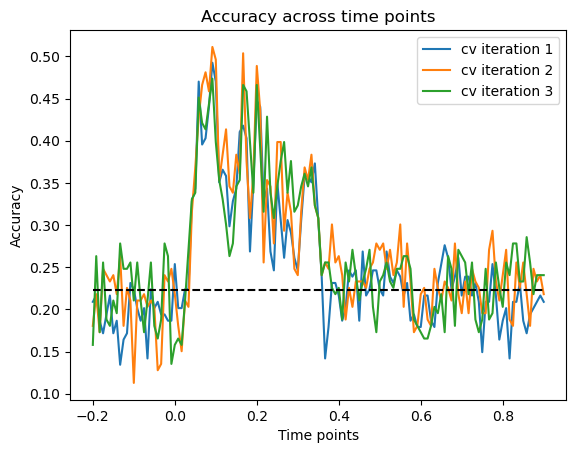

In [101]:
# MNE has a tool to avoid manually looping over the time points -> use the slidingEstimator 
all_scores = list()
# For each cross validation fold
for train, test in kf.split(X_time_points,y):
    # Get the corresponding train and test data and labels
    X_train = X_time_points[train]
    X_test = X_time_points[test]
    y_train = y[train]
    y_test = y[test]
    # Select the pipeline object to use
    model = lr
    # Instantiate the sliding estimator object
    sliding_est = SlidingEstimator(model, n_jobs=-1,scoring='accuracy')
    # Train the model
    sliding_est.fit(X_train, y_train)
    # Get model scores (here accuracy as specified when instantiating the sliding estimator)
    scores = sliding_est.score(X_test,y_test)
    all_scores.append(scores)
    # For each fold; plot the scores for each time points
    plt.plot(epochs.times, scores)
    plt.title("Accuracy across time points")
    plt.xlabel("Time points")
    plt.ylabel("Accuracy")
    plt.legend(['cv iteration 1','cv iteration 2','cv iteration 3'])
plt.plot(epochs.times,np.repeat(np.mean(chance_levels)/100,len(epochs.times)),'--',color='black')

Text(0, 0.5, 'Accuracy')

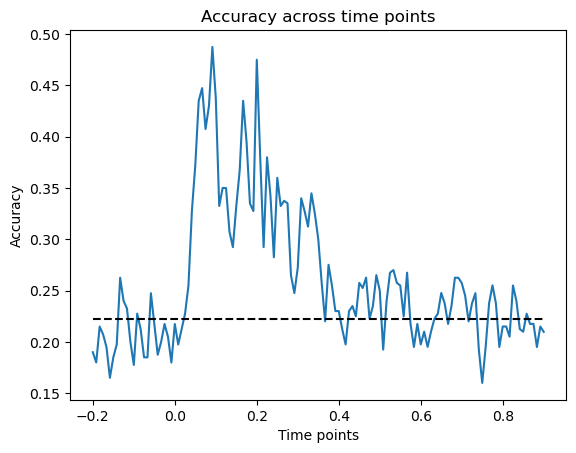

In [85]:
    plt.plot(epochs.times, np.mean(all_scores, 0))
    plt.plot(epochs.times,np.repeat(np.mean(chance_levels)/100,len(epochs.times)),'--',color='black')
    plt.title("Accuracy across time points averaged over all cv iterations")
    plt.xlabel("Time points")
    plt.ylabel("Accuracy")

# Across time points training/testing with Generalizing estimator

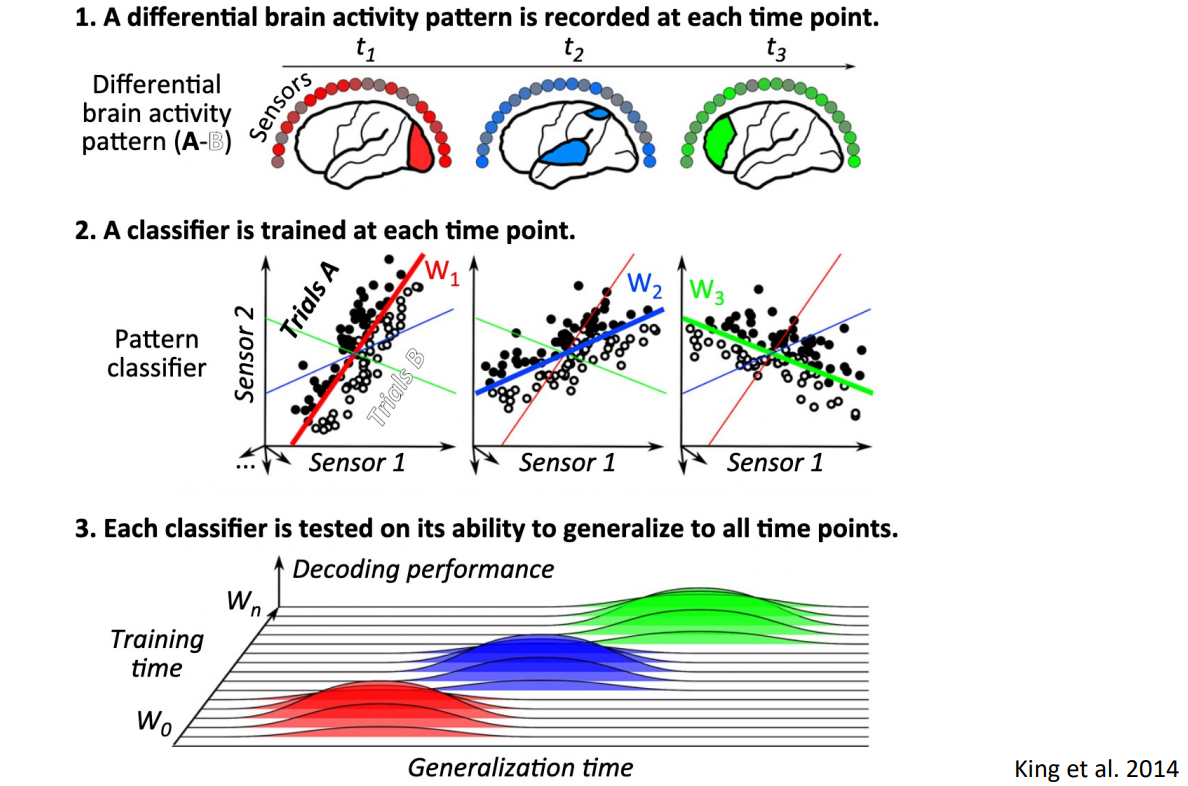

  0%|          | Fitting GeneralizingEstimator : 0/60 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/3600 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/60 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/3600 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/60 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/3600 [00:00<?,       ?it/s]

<Figure size 1500x500 with 0 Axes>

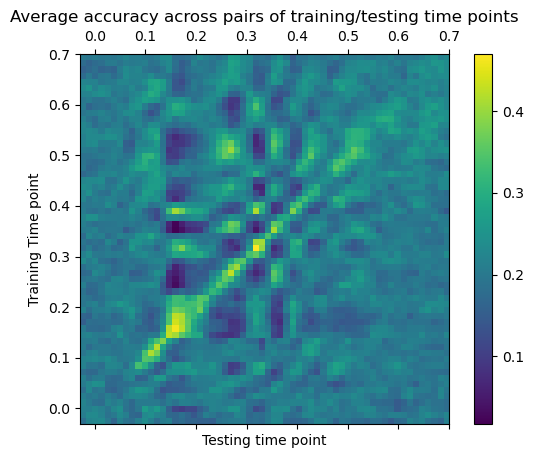

In [95]:
# Testing time point specific models on all other time points 

plt.figure(figsize=(15,5))
all_scores=[]
# For each cross validation fold
for train, test in kf.split(X_windows,y):
    # Get the corresponding train and test data and labels
    X_train = X_time_points[train][:,:,20:80]
    X_test = X_time_points[test][:,:,20:80]
    y_train = y[train]
    y_test = y[test]
    # Select the pipeline object to use
    model = lr
    # Instantiate the GeneralizingEstimator object
    gen_est = GeneralizingEstimator(lr, n_jobs=-1,scoring='accuracy')
    # Train the model
    gen_est.fit(X_train, y_train)
    # Get model scores (here accuracy as specified when instantiating the sliding estimator)
    # scores (for each fold) is a matrix containing the score for each pair of training/testing time point
    scores = gen_est.score(X_test,y_test)
    all_scores.append(scores)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(np.array(all_scores).mean(axis=0), origin='lower', extent=[-0.03,0.7,-0.03,0.7])
plt.title("Average accuracy across pairs of training/testing time points")
plt.xlabel("Testing time point")
plt.ylabel("Training Time point")    
fig.colorbar(cax)
plt.show()


# Accross participants training/testing

<div class="alert alert-success">
    <b>Exercise</b>: Modify the code from the next cell, which implements classification on windows, to train on subject 1 and test on subjet 2.<br />
     <b>Hints</b>: We don't need to use cross validation anymore! Train and test data and labels should be changed
</div>

classification accuracy for cv iteration0:
0.6194029850746269
classification accuracy for cv iteration1:
0.6240601503759399
classification accuracy for cv iteration2:
0.6466165413533834
Mean classification accuracy across folds:  0.6300265589346501
Confusion matrix across folds: 


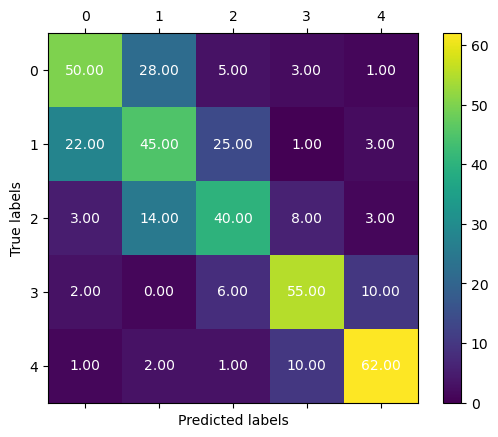

In [28]:
# Decoding the spatial frequency of the gabor stimuli from a short time window of MEG data sampled after the stimuli appears 

# Creating variables to store result metrics from each cross validation fold
accuracy=[]
conf_matrix=np.zeros((5,5))
fold=0
# For each cross validation fold
for train, test in kf.split(X_windows,y):
    # Get the corresponding train and test data and labels
    X_train = X_windows[train]
    X_test = X_windows[test]
    y_train = y[train]
    y_test = y[test]
    # Select the pipeline object to use
    model = lr
    # Train the model with the train data
    model.fit(X_train, y_train)
    # Test the model with the test data
    # Return model predictions (int from 0 to 5)
    y_pred = model.predict(X_test)
    # Compute metrics by comparing predictions and ground truth labels
    accuracy_result = accuracy_score(y_test.astype('int64'),y_pred.astype('int64'))
    conf_matrix = conf_matrix + confusion_matrix(y_test.astype('int64'),y_pred.astype('int64'))
    # Print individual fold results
    print("classification accuracy for cv iteration"+str(fold)+":")
    print(accuracy_result)
    accuracy.append(accuracy_result)
    fold=fold+1

# Print average across folds
print("Mean classification accuracy across folds: ", np.mean(accuracy))
print("Confusion matrix across folds: ")
# Print confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)
for (i, j), value in np.ndenumerate(conf_matrix):
    plt.text(i, j, f"{value:.2f}", va="center", ha="center",c="white")
fig.colorbar(cax)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()